# Dopamine modulation on BG

**Observation**: increase in beta-range spectral power is observed without dopamine modulation of CTX input to MSN-D1 and MSN-D2.

**Method**: I used the network model from Ortone and the model of dopamine modulation from Lindahl(2016). In particular, if an attribute $x$ of the network is subject to dopaminergic modulation, the effect of dopamine levels are modeled by

$$ x(\alpha) = x_0(1+\chi_x (\alpha -\alpha_0))$$
where $\alpha$ represents the dopamine level and $x_0$ is the value of the parameter at standard dopamine ($\alpha_0 = 0.8$, Lindahl). In the following, $\chi_x$ will be called generalized susceptibility.

The **main differences** between Ortone and Lindahl networks are:

- size of populations
- synaptic model
- cortical inputs: no AMPA/NMDA differentiation, different rates and weights
- STN subthreshold/suprathreshold adaptation parameter ada_a (Ortone: 0, Lindahl 0.3)
- Rest potential of FSN (Ortone: -80, Lindahl: -64.4). This attribute is negatively susceptible to dopamine, so FSN in Lindahl's network is already dopamine-depleted w.r.t. Ortone's network;
- SNr synaptic fan-in (from MSN-D1 Ortone: 59, Lindahl: 500; from GPeTI Ortone:25, Lindahl: 32 ). This is not particularly relevant for now since SNr is an output;

In [1]:
import yaml
from rich import print

NEURONS_FILE = "ortone_neurons.yaml"
NETWORK_FILE = "ortone_network.yaml"
DOPAMINE_FILE = "lindahl_dopamine_susceptibility_noctx.yaml"

print("List of dopamine-dependent attributes:")
with open(DOPAMINE_FILE, "r") as dopfile:
    susceptiblities = yaml.safe_load(dopfile)['parametric']['dopamine']

for item in susceptiblities:
    if 'population' in item.keys():
        print(f"Attribute {item['attribute']:15} of population {item['population']:15}: chi = {item['susceptibility']}")
    elif 'projection' in item.keys():
        print(f"Attribute {item['attribute']:10} of projection {item['projection']:15}: chi = {item['susceptibility']}")

List of dopamine-dependent attributes:

Attribute E_l             of population FSN            : chi = -0.078

Attribute E_l             of population GPeTA, GPeTI   : chi = -0.181

Attribute V_peak          of population D1             : chi = 0.0296

Attribute ada_b           of population D1             : chi = -0.45

Attribute E_l             of population SNR            : chi = -0.0896

Attribute weight     of projection FSN->FSN       : chi = -1.27

Attribute weight     of projection GPeTA->FSN     : chi = -0.53

Attribute weight     of projection GPeTI->FSN     : chi = -0.53

Attribute weight     of projection GPeTA->GPeTA, GPeTA->GPeTI, GPeTI->GPeTI,  GPeTI->GPeTA: chi = -0.83

Attribute weight     of projection D2->GPeTI      : chi = -0.83

Attribute weight     of projection STN->GPeTA     : chi = -0.45

Attribute weight     of projection STN->GPeTI     : chi = -0.45

Attribute connectivity of projection FSN->D2        : chi = -0.9

Attribute connectivity of projection D1->D1, D1->D2, D2->D1, D2->D2: chi = 0.88

Attribute weight     of projection D1->D1, D1->D2, D2->D1, D2->D2: chi = 0.88

Attribute weight     of projection GPeTA->D1      : chi = -1.15

Attribute weight     of projection D1->SNR        : chi = 0.56

Attribute weight     of projection GPeTI->STN     : chi = -0.24

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext wurlitzer
%matplotlib inline
# %matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


## Parameters of the simulation

In [3]:
Tlong = 8000  # ms
dt = 0.1      # ms

points_per_bin = 1/dt     # bins 1 ms wide
sampling_frequency = 1e3  # 1 kHz sampling frequency
burn_in_millis = 600      # the first part of the record to discard (ms)

# Params for trials
n_trials = 10
Tshort = 1500 # ms

# Rescaling of populations: Lindahl network is unbearable on my machine
# so populations are rescaled to match sizes from Ortone
populations_scaling = dict()
if NETWORK_FILE == "lindahl_network.yaml":
    populations_scaling = dict( MSN_scale= -0.84,
                                FSN_scale= -0.74,
                                GPe_scale= -0.22,
                                STN_scale= 0.05
                                )

reasonable_firing = dict(FSN=15, D1=1.5, D2=1.5, GPeTI=50, GPeTA=10, STN=16)
# FSN [10-20] Hz 
# D1, D2 [0.5–2.5] Hz
# GPe-TI [40–60] Hz
# GPe-TA [5–15] Hz 
# and STN [12–20] Hz


## Utils & plots

In [4]:
from scipy.signal import butter, sosfiltfilt, freqz, welch
from scipy.integrate import simpson
from scipy import stats

def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data('spikes')
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    T = len(binned_spikes)
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = T/2, # Takes at least 3 windows
                   noverlap= T/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    norm = simpson(PSD, x=f)
    # print(f"f peak of {population} is {f[np.argmax(PSD)]} Hz")
    beta_mask = (f>12)&(f<30)
    beta_pow = simpson(PSD[beta_mask], x=f[beta_mask])
    # freq of max, normlized beta power, beta power, entropy
    return f[np.argmax(PSD)], beta_pow/norm, beta_pow, stats.entropy(PSD/norm)

def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

def get_PSD(sn, pop, frequency_resolution=0.5, smooth=False):
    spikes = sn.populations[pop].get_data('spikes')
    binned_spikes = bin_spikes(spikes)
    binned_spikes = binned_spikes[burn_in_millis:]
    T = len(binned_spikes)
    # print(f"Mean firing rate {pop} is {np.sum(spikes)/sn.populations[pop].n_neurons/(Tlong/1000) :.1f} Hz")

    N = sampling_frequency/frequency_resolution
    
    if N > T/2:
        print(N)
        print(f"Not enough points to achieve resolution of {frequency_resolution}")
        N = T/2

    nfft = 10_000 if smooth else None
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg=N, 
                   noverlap=N/2,
                   nfft=nfft,
                   scaling='density', 
                   window='hamming')
    # print(f"F resolution { f[1] - f[0] :.2f} Hz")
    norm = simpson(PSD, x=f)
    return f, PSD

In [5]:
def plot_spectrum(sn, scale="log", pops=None):
    if pops is None:
        pops = sn.populations
    fig, axes = plt.subplots(len(pops), 1, sharex=True)
    for ax, pop in zip(axes, pops):
        f, PSD = get_PSD(sn, pop)
        norm = simpson(PSD, x=f)
        ax.plot(f, PSD/norm, label=pop)
        
        ax.set_ylabel(pop)
        ax.set_yscale(scale)
    # print(f"F resolution { f[1] - f[0] :.2f} Hz")
    # plt.yscale('log')
    # plt.legend()
    # plt.ylabel("normalized PSD")
    plt.xlabel("Frequency [Hz]")
    plt.xlim(10, 30)
    fig.set_figheight(8.5)
    return fig

def plot_signals(sn, pops=None):
    if pops is None:
        pops = sn.populations.keys()
    colors = sns.color_palette("rainbow", 10)

    fig, ax = plt.subplot_mosaic([[pop] for pop in pops],sharex=True, figsize=(8,2*len(pops)))

    for pop in pops:    
        binned_spikes = bin_spikes(sn.populations[pop].get_data('spikes'))
        instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
        
        tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
        ax[pop].plot(tt, instantaneous_fr, color="#c3c3c3", label="raw")
            
        ax[pop].plot(tt,np.mean(instantaneous_fr) + bandpass(instantaneous_fr, [12, 30], sampling_frequency), label=r"$\beta$", color=colors[9])
        ax[pop].plot(tt, np.mean(instantaneous_fr)  + bandpass(instantaneous_fr, [30, 90], sampling_frequency), label=r"$\gamma$", color=colors[2])
        
        ax[pop].set_xlim(6, 7)
        ax[pop].set_ylabel(f"{pop} [Hz]")
        ax[pop].legend()
    
    leg = ax[pops[0]].get_legend()
    for a in ax.values():
        a.legend().remove()
    
    fig.legend(handles=leg.legend_handles, loc='upper right')
    
    ax[pops[-1]].set_xlabel("time [s]")
    return fig


## Building the network

In [6]:
from quilt.interface.spiking import set_verbosity
set_verbosity(1)

In [7]:
from quilt.builder import NeuronCatalogue, ParametricSpikingNetwork

sn = ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                        NEURONS_FILE,
                                        [DOPAMINE_FILE], 
                                         # DISPERSION_FILE, "dbs.yaml"]
                                       )
sn.monitorize_spikes()
# sn.monitorize_states("GPeTA")

## Control case (healthy subject)

In [8]:
sn.set_parameters(dopamine=1.0)
sn.run(dt=dt, time=Tlong)

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 132 s	(1.6541 ms/step)
	Gathering time avg: 0.0746125 us/step
	Inject time avg: 163.692 us/step
Population evolution stats:
	0:
		evolution:	450.364 us/step	---	75 ns/step/neuron
		spike emission:	36.9539 us/step	---	6 ns/step/neuron
	1:
		evolution:	438.578 us/step	---	73 ns/step/neuron
		spike emission:	64.0373 us/step	---	10 ns/step/neuron
	2:
		evolution:	85.0627 us/step	---	202 ns/step/neuron
		spike emission:	11.9305 us/step	---	28 ns/step/neuron
	3:
		evolution:	113.073 us/step	---	144 ns/step/neuron
		spike emission:	21.9056 us/step	---	28 ns/step/neuron
	4:
		evolution:	61.5661 us/step	---	236 ns/step/neuron
		spike emission:	5.51949 us/step	---	21 ns/step/neuron
	5:
		evolution:	72.6382 us/step	---	178 ns/step/neuron
		spike emission:	4.93041 us/step	---	12 ns/step/neuron
	6:
		evolution:	110.653 

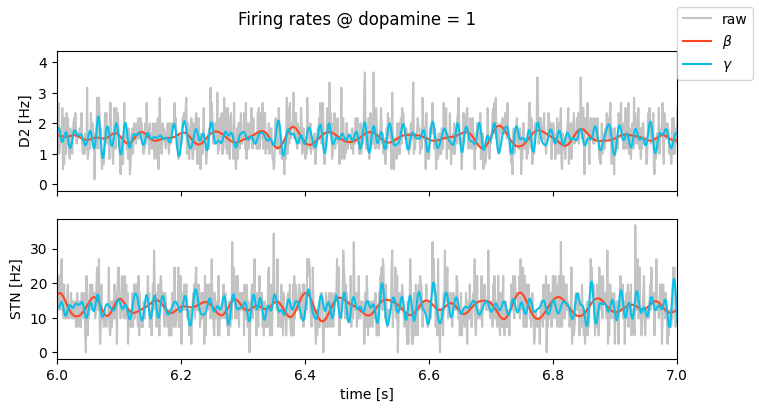

In [9]:
plot_signals(sn, pops=['D2', 'STN']);
plt.gcf().suptitle('Firing rates @ dopamine = 1');

## Lesioned case (PD)

In [10]:
sn.set_parameters(dopamine=0.4)
sn.run(dt=dt, time=Tlong)

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 128 s	(1.60194 ms/step)
	Gathering time avg: 0.0805 us/step
	Inject time avg: 161.229 us/step
Population evolution stats:
	0:
		evolution:	435.46 us/step	---	72 ns/step/neuron
		spike emission:	52.2633 us/step	---	8 ns/step/neuron
	1:
		evolution:	421.136 us/step	---	70 ns/step/neuron
		spike emission:	51.7486 us/step	---	8 ns/step/neuron
	2:
		evolution:	80.7657 us/step	---	192 ns/step/neuron
		spike emission:	12.7791 us/step	---	30 ns/step/neuron
	3:
		evolution:	109.632 us/step	---	140 ns/step/neuron
		spike emission:	17.1962 us/step	---	22 ns/step/neuron
	4:
		evolution:	60.3721 us/step	---	232 ns/step/neuron
		spike emission:	3.83675 us/step	---	14 ns/step/neuron
	5:
		evolution:	70.4602 us/step	---	172 ns/step/neuron
		spike emission:	5.35121 us/step	---	13 ns/step/neuron
	6:
		evolution:	106.761 us/s

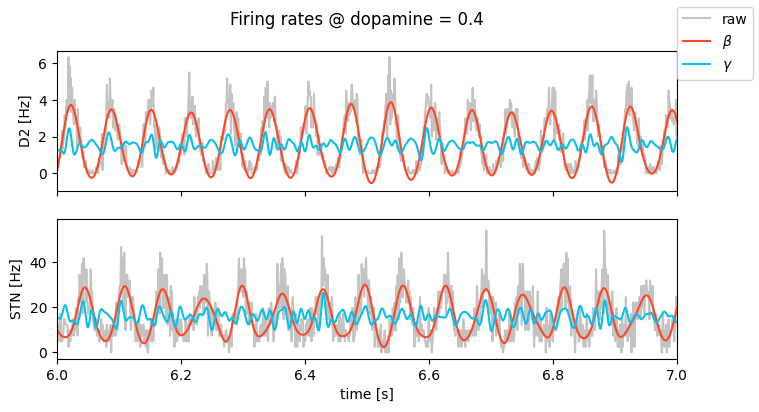

In [11]:
plot_signals(sn, pops=['D2', 'STN']);
plt.gcf().suptitle('Firing rates @ dopamine = 0.4');

ValueError: x and y must have same first dimension, but have shapes (2000,) and (1500,)

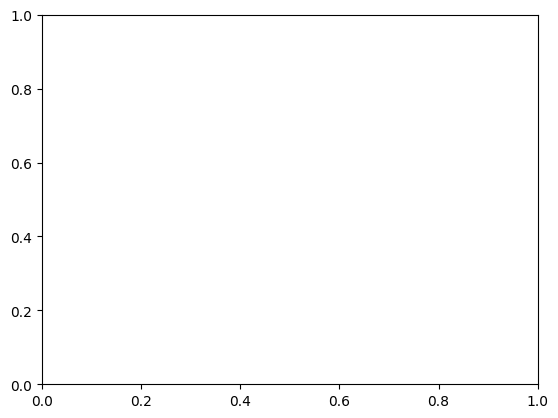

In [177]:
fig, ax = plt.subplots()
tt = np.arange(0,2000)
signal = bin_spikes(sn.populations['STN'].get_data('spikes')[:10*len(tt)])
plt.plot(tt, signal )

from scipy.integrate import odeint
print(len(signal))
def f(y, t):
    global signal
    tau = 10
    # print(t)
    i = max(min(int(t)+tau, len(signal)-1), 0)
    return 1/tau*(-y + signal[i])
sol = odeint(f, signal[0], tt)
plt.plot(tt, sol)
plt.xlim(1500, 2000)

## Comparison

In [23]:
dopamines = [0.6, 0.7, 0.8, 0.9, 1]

nets = []
for dopamine in dopamines:
    nets.append(ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                            NEURONS_FILE,
                                            [DOPAMINE_FILE]))
    nets[-1].set_parameters(dopamine=dopamine)
    nets[-1].monitorize_spikes()

In [24]:
for net in nets:
    net.run(dt=dt, time=Tlong)

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 141 s	(1.76616 ms/step)
	Gathering time avg: 0.034625 us/step
	Inject time avg: 187.085 us/step
Population evolution stats:
	0:
		evolution:	489.751 us/step	---	81 ns/step/neuron
		spike emission:	77.9085 us/step	---	12 ns/step/neuron
	1:
		evolution:	437.217 us/step	---	72 ns/step/neuron
		spike emission:	71.6764 us/step	---	11 ns/step/neuron
	2:
		evolution:	86.4559 us/step	---	205 ns/step/neuron
		spike emission:	14.4197 us/step	---	34 ns/step/neuron
	3:
		evolution:	111.494 us/step	---	142 ns/step/neuron
		spike emission:	21.2745 us/step	---	27 ns/step/neuron
	4:
		evolution:	62.6514 us/step	---	240 ns/step/neuron
		spike emission:	4.6347 us/step	---	17 ns/step/neuron
	5:
		evolution:	72.8672 us/step	---	178 ns/step/neuron
		spike emission:	6.05361 us/step	---	14 ns/step/neuron
	6:
		evolution:	108.714 

IOStream.flush timed out


Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 130 s	(1.63701 ms/step)
	Gathering time avg: 0.0452 us/step
	Inject time avg: 175.529 us/step
Population evolution stats:
	0:
		evolution:	429.647 us/step	---	71 ns/step/neuron
		spike emission:	68.7478 us/step	---	11 ns/step/neuron
	1:
		evolution:	410.264 us/step	---	68 ns/step/neuron
		spike emission:	65.2782 us/step	---	10 ns/step/neuron
	2:
		evolution:	81.3065 us/step	---	193 ns/step/neuron
		spike emission:	13.3239 us/step	---	31 ns/step/neuron
	3:
		evolution:	108.873 us/step	---	139 ns/step/neuron
		spike emission:	21.3583 us/step	---	27 ns/step/neuron
	4:
		evolution:	61.4502 us/step	---	236 ns/step/neuron
		spike emission:	4.27814 us/step	---	16 ns/step/neuron
	5:
		evolution:	71.5834 us/step	---	175 ns/step/neuron
		spike emission:	5.48179 us/step	---	13 ns/step/neuron
	6:
		evolution:	105.918 u

IOStream.flush timed out


Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 140 s	(1.75831 ms/step)
	Gathering time avg: 0.129637 us/step
	Inject time avg: 186.533 us/step
Population evolution stats:
	0:
		evolution:	464.182 us/step	---	77 ns/step/neuron
		spike emission:	62.7732 us/step	---	10 ns/step/neuron
	1:
		evolution:	443.89 us/step	---	73 ns/step/neuron
		spike emission:	75.527 us/step	---	12 ns/step/neuron
	2:
		evolution:	88.3833 us/step	---	210 ns/step/neuron
		spike emission:	14.0869 us/step	---	33 ns/step/neuron
	3:
		evolution:	117.239 us/step	---	150 ns/step/neuron
		spike emission:	24.2248 us/step	---	31 ns/step/neuron
	4:
		evolution:	65.1241 us/step	---	250 ns/step/neuron
		spike emission:	5.76574 us/step	---	22 ns/step/neuron
	5:
		evolution:	75.848 us/step	---	185 ns/step/neuron
		spike emission:	5.76634 us/step	---	14 ns/step/neuron
	6:
		evolution:	114.669 us

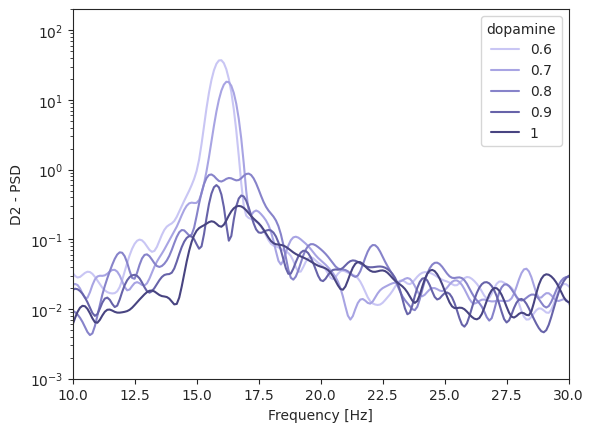

In [25]:
fig, ax = plt.subplots()
D2_colors = sns.cubehelix_palette(start=0, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=len(nets), hue=1)
STN_colors = sns.cubehelix_palette(start=1.3, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=len(nets), hue=1)

sns.set_style("ticks")

for i in range(len(nets)):
    ax.plot(*get_PSD(nets[i], "D2", frequency_resolution=0.5, smooth=True), label=dopamines[i], color=D2_colors[i])

ax.set_yscale('log')
ax.set_xlim(10, 30)
plt.legend(title="dopamine")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("D2 - PSD")
ax.set_ylim(1e-3, 2e2)
plt.savefig("images/D2-PSD.pdf")

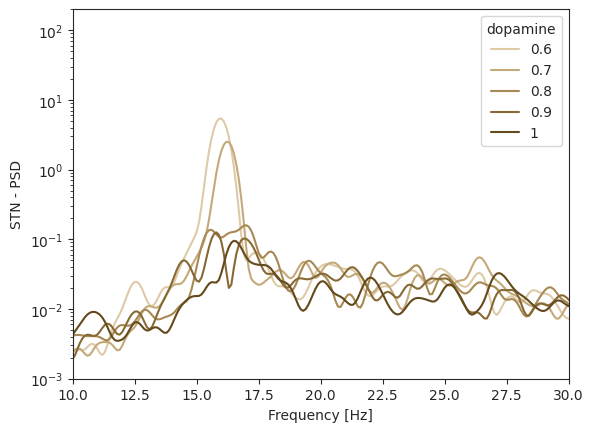

In [26]:
fig, ax = plt.subplots()
STN_colors = sns.cubehelix_palette(start=1.3, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=len(nets), hue=1)

sns.set_style("ticks")

for i in range(len(nets)):
    ax.plot(*get_PSD(nets[i], "STN", frequency_resolution=0.5, smooth=True), label=dopamines[i], color=STN_colors[i])
    # ax.plot(*get_PSD(nets[i], "STN"), label="STN", color=STN_colors[i])
ax.set_yscale('log')
ax.set_xlim(10, 30)
plt.legend(title="dopamine")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("STN - PSD")
ax.set_ylim(1e-3, 2e2)
plt.savefig("images/STN-PSD.pdf")

## Trend

In [27]:
from rich.progress import track

set_verbosity(0)
beta_powers = dict()
fmaxs = dict()
beta_powers_normalized = dict()
entropies = dict()

for pop in sn.spike_monitored_pops:
    fmaxs[pop] = []
    beta_powers[pop] = []
    beta_powers_normalized[pop] = []
    entropies[pop] = []
    
dopamine_levels = np.linspace(0.2, 0.9, 20)

for dopamine in track(dopamine_levels, total=len(dopamine_levels)):
    sn.set_parameters(dopamine=dopamine)
    sn.run(dt=dt, time=1600)
    for pop in sn.populations.keys():
        fmax, normbeta, beta, entropy = beta_power(sn, pop)
        fmaxs[pop] += [fmax]
        beta_powers_normalized[pop] += [normbeta]
        beta_powers[pop] += [beta]
        entropies[pop] += [entropy]

Output()

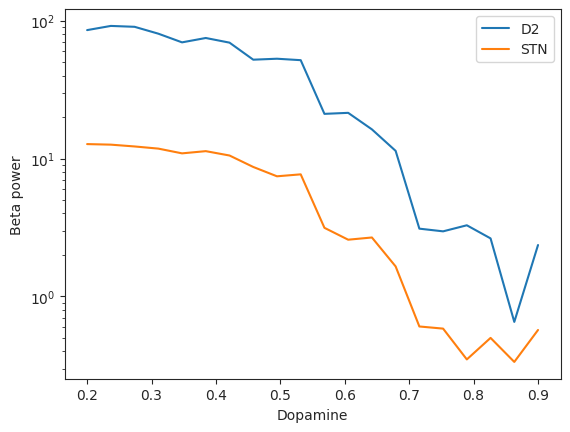

In [35]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, beta_powers[pop], label=pop)
plt.ylabel("Beta power")
plt.xlabel("Dopamine")
plt.yscale('log')
plt.legend()

(13.0, 17.0)

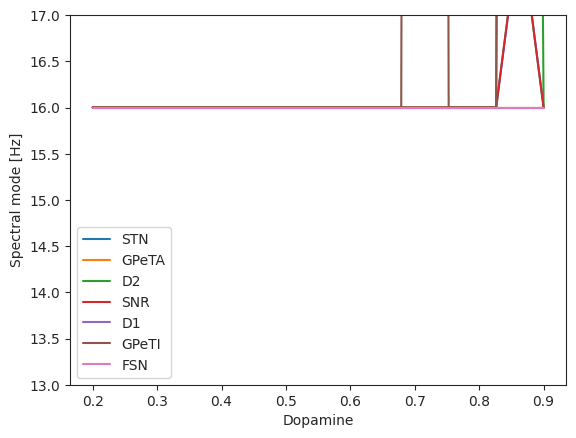

In [34]:
for pop in fmaxs:
    plt.plot(dopamine_levels, fmaxs[pop], label=pop)
# plt.yscale('log')
plt.ylabel("Spectral mode [Hz]")
plt.xlabel("Dopamine")
plt.legend()
plt.ylim(13, 17)

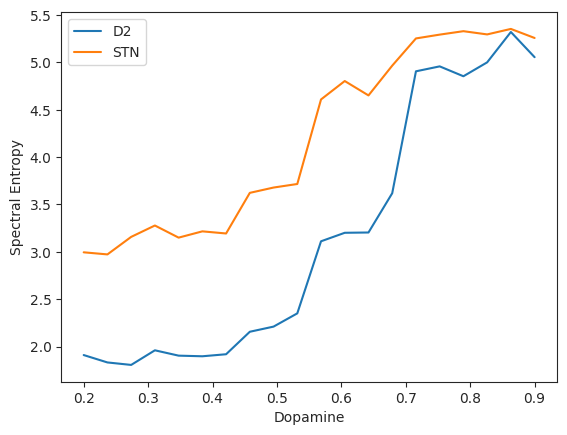

In [30]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, entropies[pop], label=pop)
# plt.yscale('log')
plt.xlabel("Dopamine")
plt.ylabel("Spectral Entropy")
plt.legend()

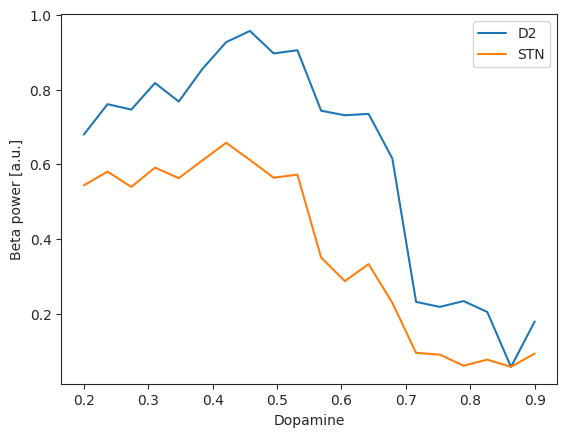

In [31]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, beta_powers_normalized[pop], label=pop)
# plt.yscale('log')
plt.ylabel("Beta power [a.u.]")
plt.xlabel("Dopamine")
plt.legend()

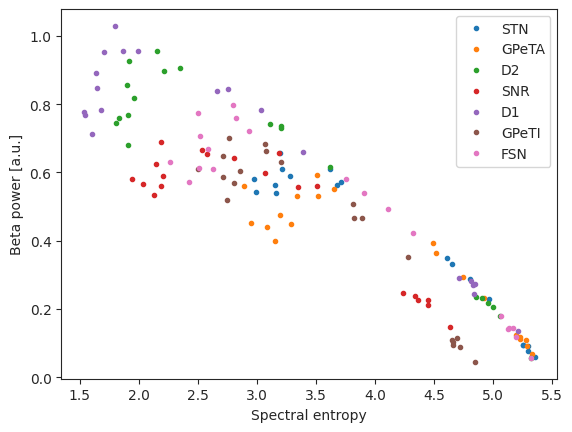

In [32]:
for pop in beta_powers_normalized:
    plt.plot(entropies[pop], beta_powers_normalized[pop], label=pop, ls="", marker=".")
plt.xlabel("Spectral entropy")
plt.ylabel("Beta power [a.u.]")
plt.legend()

## plot 2D

In [ ]:
from scipy.integrate import simpson
def bin_spectrum(f, PSD, n_bins=20, fmax=90):
    norm = simpson(PSD[f<fmax], x=f[f<fmax])
    
    binned_spectrum = np.zeros(n_bins)
    frequency_bin_width = fmax/n_bins
    for i in range(n_bins):
        f_mask = (f > i*frequency_bin_width)&(f < (i+1)*frequency_bin_width)
        # binned_spectrum[i] = simpson(PSD[f_mask], x=f[f_mask])/norm
    return binned_spectrum

In [ ]:
from rich.progress import track

set_verbosity(0)

spectral_resolution = 2.5
N_dopamine_levels = int(90/spectral_resolution)
N_spectral_bins = int(90/spectral_resolution)
dopamine_levels = np.linspace(0.2, 1.0, N_dopamine_levels)

spectra = dict()
for pop in sn.features_dict['populations']:
    spectra[pop] = np.zeros((N_dopamine_levels, N_spectral_bins))

for i in track(range(N_dopamine_levels), total=len(dopamine_levels)):
    sn.set_parameters(dopamine=dopamine_levels[i], 
                      delay_dispersion=-1, 
                      **populations_scaling)
    sn.run(dt=dt, time=3 * sampling_frequency/spectral_resolution + burn_in_millis ) # Uses 3 complete windows at minimal resolution
    for pop in sn.populations.keys():
        f, PSD = get_PSD(sn, pop, frequency_resolution=spectral_resolution)
        plt.show()
        spectra[pop][i] = PSD[f<90]
    

In [ ]:
X, Y = np.meshgrid(dopamine_levels, np.linspace(0, 90, int(90/spectral_resolution)))
# pop = "GPeTA"
for pop in sn.populations:
    plt.pcolormesh(X, Y, np.log10(spectra[pop].T + 1e-10))
    plt.xlabel("Dopamine")
    plt.ylabel("Frequency [Hz]")
    plt.colorbar(label = "Log PSD")
    plt.title(f"{pop} - PSD")
    plt.savefig(f"images/logPSD_{pop}.pdf")
    plt.show()

## Statistical features of the signal

In [138]:
def plot_spikecount_distrib(sn):
    for pop in sn.populations:
        fig, (ax1, ax2) = plt.subplots(2,1)
        ax1.set_title(pop)
        spikes = sn.populations[pop].get_data('spikes')
        spikes = spikes[5000:]
        ax2.plot(spikes)
        # ax2.plot(bin_spikes(spikes))
        from scipy.special import factorial
        nn = np.arange(np.min(spikes), np.max(spikes))
        histogram, bins = np.histogram(spikes, bins=nn, density=True)
        ax1.step(bins[:-1], histogram, where='mid', marker=".", label="Spike count")
        l = np.mean(spikes)
        print(l)
        ax1.step(nn, l**nn*np.exp(-l)/factorial(nn.astype(int)), marker=".", where='mid', label=r"Poisson ($\lambda$ = $\langle N \rangle$)")
        ax1.legend()
        plt.show()

In [140]:
sn.set_parameters(dopamine=1.0)
sn.run(dt=dt, time=Tshort)

Running network consisting of 14622 neurons for 15000 timesteps
--------------------------------------------------
**************************************************
Simulation took 27 s	(1.84288 ms/step)
	Gathering time avg: 0.0571962 us/step
	Inject time avg: 188.8 us/step
Population evolution stats:
	0:
		evolution:	507.788 us/step	---	84 ns/step/neuron
		spike emission:	61.4879 us/step	---	10 ns/step/neuron
	1:
		evolution:	479.807 us/step	---	79 ns/step/neuron
		spike emission:	84.4828 us/step	---	14 ns/step/neuron
	2:
		evolution:	91.9681 us/step	---	218 ns/step/neuron
		spike emission:	14.0446 us/step	---	33 ns/step/neuron
	3:
		evolution:	116.209 us/step	---	148 ns/step/neuron
		spike emission:	24.1784 us/step	---	30 ns/step/neuron
	4:
		evolution:	63.1586 us/step	---	242 ns/step/neuron
		spike emission:	6.05813 us/step	---	23 ns/step/neuron
	5:
		evolution:	73.6533 us/step	---	180 ns/step/neuron
		spike emission:	5.17332 us/step	---	12 ns/step/neuron
	6:
		evolution:	112.299 u

0.42425757424257576

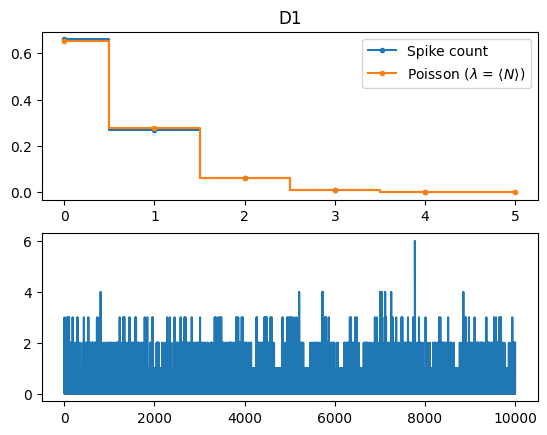

0.9667033296670333

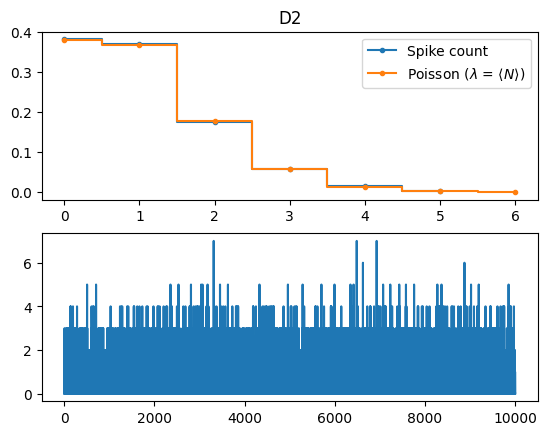

0.7015298470152985

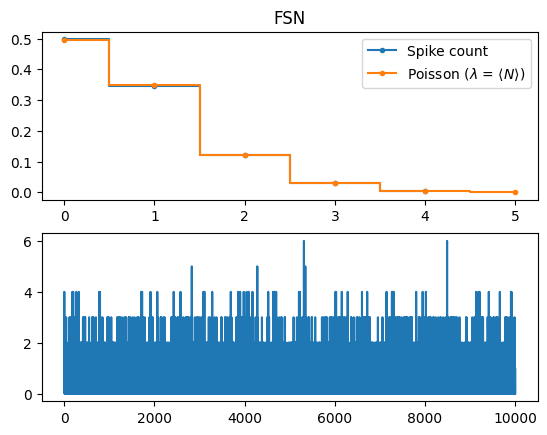

5.096090390960904

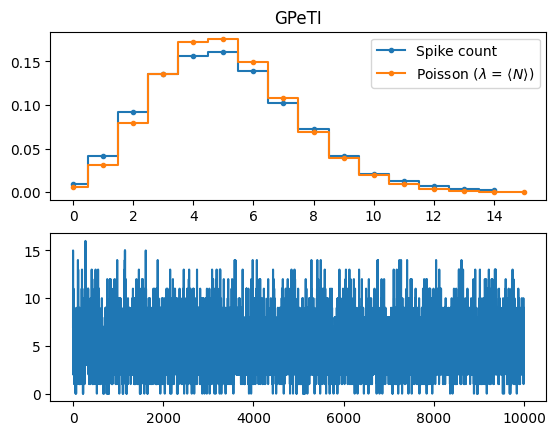

0.250974902509749

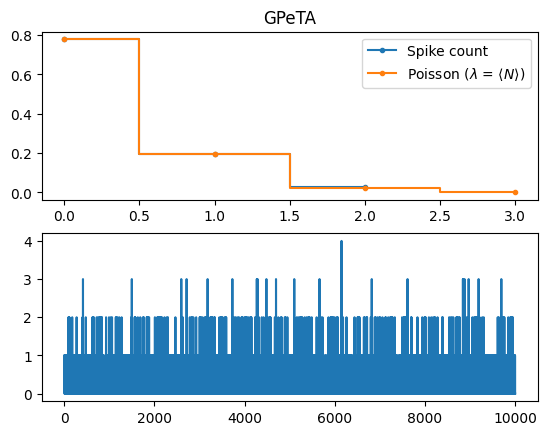

0.5445455454454554

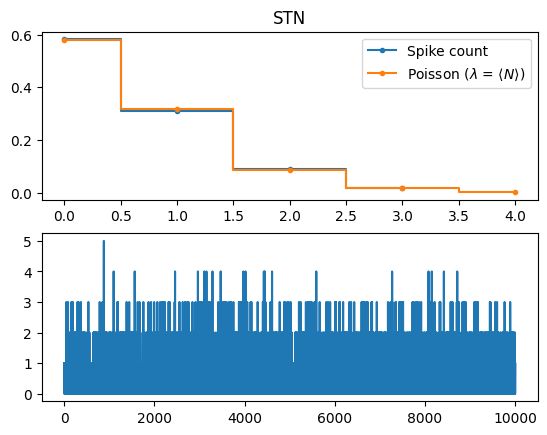

1.0186981301869813

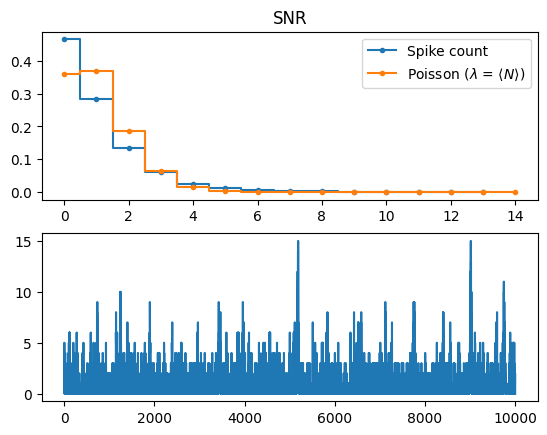

In [141]:
plot_spikecount_distrib(sn)

In [142]:
sn.set_parameters(dopamine=0.4)
sn.run(dt=dt, time=Tshort)

Running network consisting of 14622 neurons for 15000 timesteps
--------------------------------------------------
**************************************************
Simulation took 24 s	(1.66349 ms/step)
	Gathering time avg: 0.0191321 us/step
	Inject time avg: 170.769 us/step
Population evolution stats:
	0:
		evolution:	453.969 us/step	---	75 ns/step/neuron
		spike emission:	64.4178 us/step	---	10 ns/step/neuron
	1:
		evolution:	425.404 us/step	---	70 ns/step/neuron
		spike emission:	59.2918 us/step	---	9 ns/step/neuron
	2:
		evolution:	83.1975 us/step	---	198 ns/step/neuron
		spike emission:	12.8283 us/step	---	30 ns/step/neuron
	3:
		evolution:	110.351 us/step	---	141 ns/step/neuron
		spike emission:	19.2656 us/step	---	24 ns/step/neuron
	4:
		evolution:	62.6107 us/step	---	240 ns/step/neuron
		spike emission:	3.955 us/step	---	15 ns/step/neuron
	5:
		evolution:	70.6614 us/step	---	173 ns/step/neuron
		spike emission:	5.75975 us/step	---	14 ns/step/neuron
	6:
		evolution:	107.405 us

1.7903209679032097

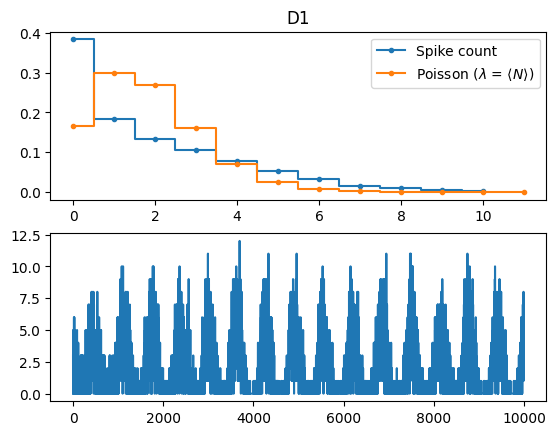

0.9617038296170383

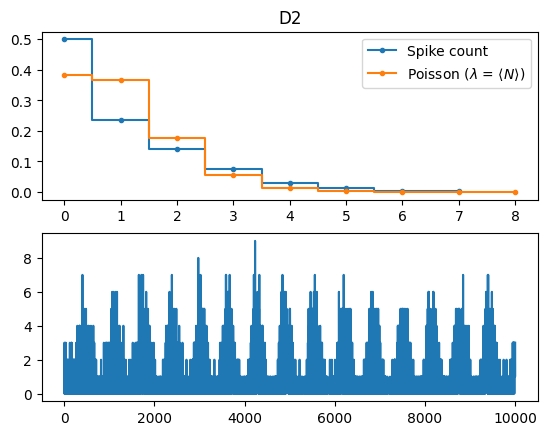

0.6118388161183882

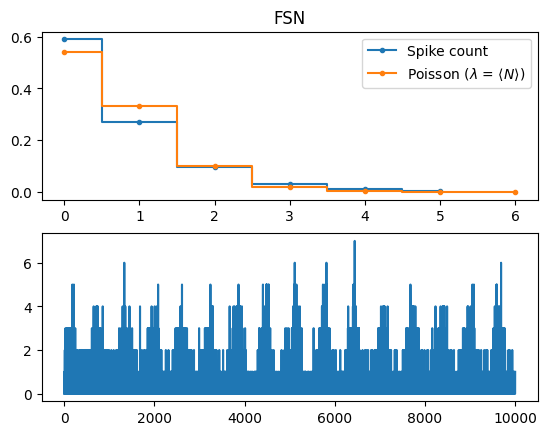

3.9148085191480853

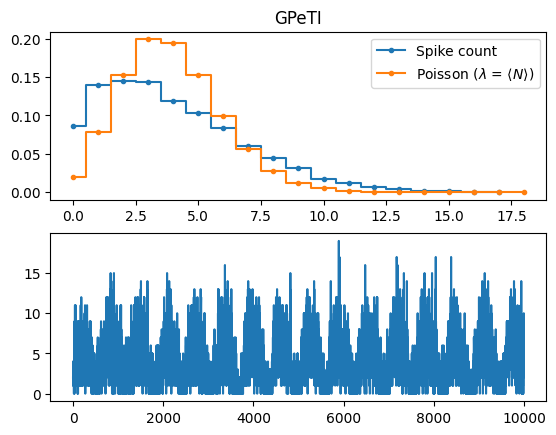

0.15528447155284472

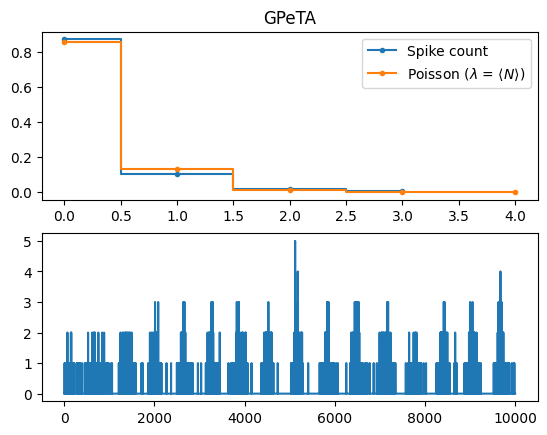

0.662933706629337

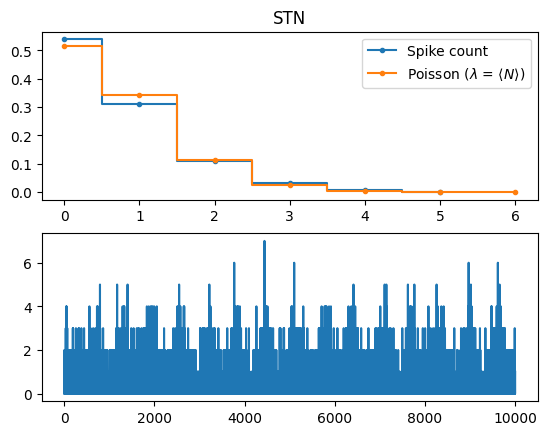

7.371762823717628

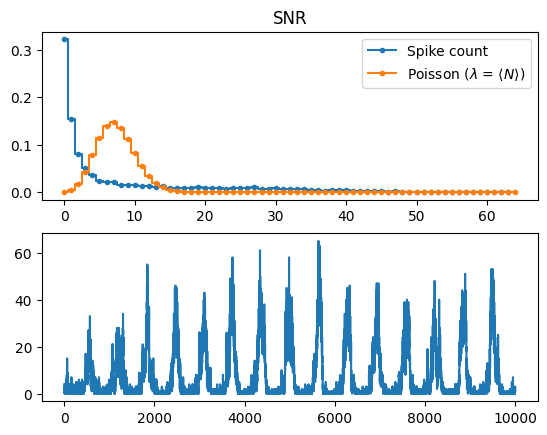

In [144]:
plot_spikecount_distrib(sn)

## Estimating rate functions

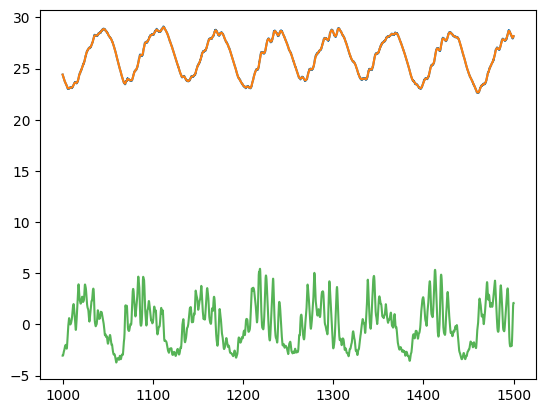

In [222]:
spikes = sn.populations['GPeTI'].get_data('spikes')
tt = np.linspace(0, Tshort, len(spikes))

mask = tt >1000

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(tt[mask].reshape(-1,1), np.cumsum(spikes)[mask])

m_fit = model.coef_[0]
b_fit = model.intercept_ 
L = np.cumsum(spikes)[mask] - m_fit*tt[mask]
plt.plot(tt[mask], 0.01*L)
for j in range(15):
    for i in range(1, len(tt[mask])-1):
        L[i] = 0.5*(L[i+1] + L[i-1])
plt.plot(tt[mask], 0.01*L)
plt.plot(tt[mask][:-1], 0.1*np.diff(L)/np.diff(tt[mask]), alpha=0.8)
# plt.ylim(0, 0.25)

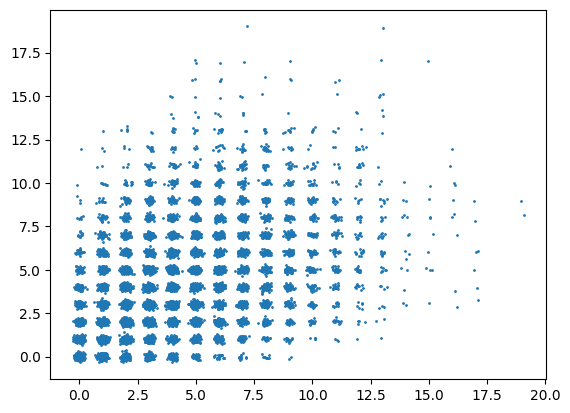

In [225]:
k = 5 
plt.scatter(spikes[:-k]+np.random.normal(0, 0.1, size=len(spikes[:-k])), spikes[k:]+np.random.normal(0, 0.1, size=len(spikes[:-k])), s=1)

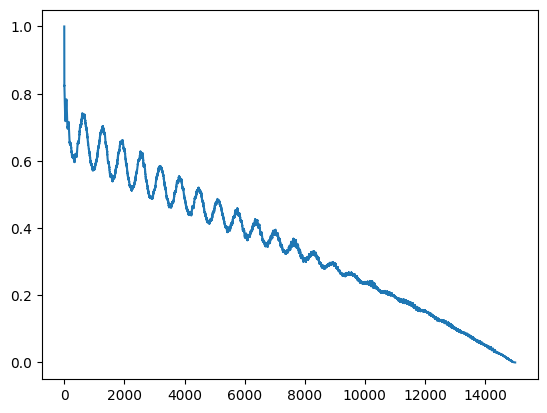

In [226]:
from scipy.signal import correlate
gg = correlate(spikes, spikes, mode='full')/np.std(spikes)**2
gg = gg[len(gg)//2:]
gg /= gg[0]
plt.plot(gg)

(0.0, 1000.0)

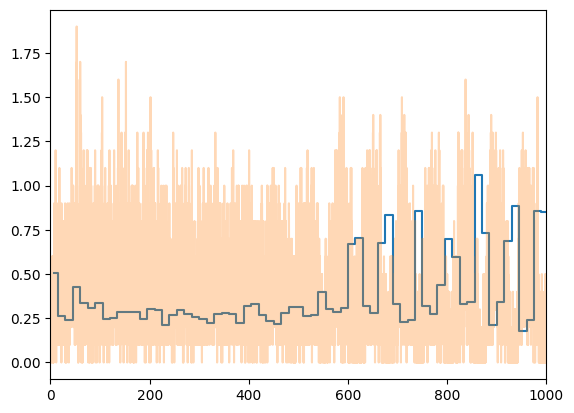

In [257]:
cvs = []
times = []
k = 100
for bunch, ttt in zip(np.split(spikes[:-(len(spikes)%k)], k),
                     np.split(tt[:-(len(spikes)%k)], k)):
    times.append(0.5*(ttt[0] + ttt[-1]))
    cvs.append(np.std(bunch)**2/np.mean(bunch)**2)
plt.step(times, cvs, where='mid')
plt.plot(tt, spikes/10, alpha=0.3)
plt.xlim(0, 1000)